Import Libs

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import tensorflow as tf
from tensorflow.keras.layers import Rescaling
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
data_dir = r"C:\Users\Karan\Desktop\datascience\Projects\Fake_Currency\datasets\fakedata\training"

In [24]:
batch_size = 5
img_height = 500
img_width = 500

In [25]:
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Create training dataset

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 4347 files belonging to 7 classes.
Using 3478 files for training.


Create validation dataset

In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4347 files belonging to 7 classes.
Using 869 files for validation.


Display class names

In [28]:
class_names = train_ds.class_names
print(class_names)

['100 Fake', '100 Real', '200 Fake', '200 Real', '50 Fake', '500 Fake', '500 Real']


Inspect a batch of images and labels

In [29]:
for image_batch, labels_batch in train_ds:
    print("Image batch shape:", image_batch.shape)  # Should print (batch_size, img_height, img_width, 3)
    print("Labels batch shape:", labels_batch.shape)  # Should print (batch_size,)
    break  # Exit after the first batch

Image batch shape: (5, 500, 500, 3)
Labels batch shape: (5,)


Create a normalization layer

In [33]:
normalization_layer = Rescaling(1./255)

In [36]:
# Apply the normalization layer to the dataset
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# Fetch a batch of images and labels
image_batch, labels_batch = next(iter(normalized_train_ds))

# Get the first image from the batch
first_image = image_batch[0]

# Print the minimum and maximum pixel values of the first image
print("Min pixel value:", np.min(first_image))
print("Max pixel value:", np.max(first_image))

Min pixel value: 0.0
Max pixel value: 1.0


model creation

In [54]:
num_classes = 7

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(7)
])

c:\Users\Karan\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 500, 500, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 500, 500, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 250, 250, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 250, 250, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,514,663 (120.22 MB)

 Trainable params: 31,514,663 (120.22 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [57]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 244s 344ms/step - accuracy: 0.7489 - loss: 1.3234 - val_accuracy: 0.8953 - val_loss: 0.2612
Epoch 2/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 234s 336ms/step - accuracy: 0.9751 - loss: 0.0974 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 246s 353ms/step - accuracy: 1.0000 - loss: 4.5074e-04 - val_accuracy: 1.0000 - val_loss: 9.9942e-05
Epoch 4/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 235s 337ms/step - accuracy: 1.0000 - loss: 7.0152e-05 - val_accuracy: 1.0000 - val_loss: 3.7441e-05
Epoch 5/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 232s 334ms/step - accuracy: 1.0000 - loss: 2.8964e-05 - val_accuracy: 1.0000 - val_loss: 1.7902e-05
Epoch 6/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 236s 339ms/step - accuracy: 1.0000 - loss: 1.4600e-05 - val_accuracy: 1.0000 - val_loss: 9.6409e-06
Epoch 7/10
696/696 ━━━━━━━━━━━━━━━━━━━━ 235s 337ms/step - accuracy: 1.0000 - loss: 7.9892e-06 - val_accuracy: 1.0000 - val_loss: 5.6101e-06
Epoch 8/10
696/696 ━━━━━━━━━━━━━━━━━

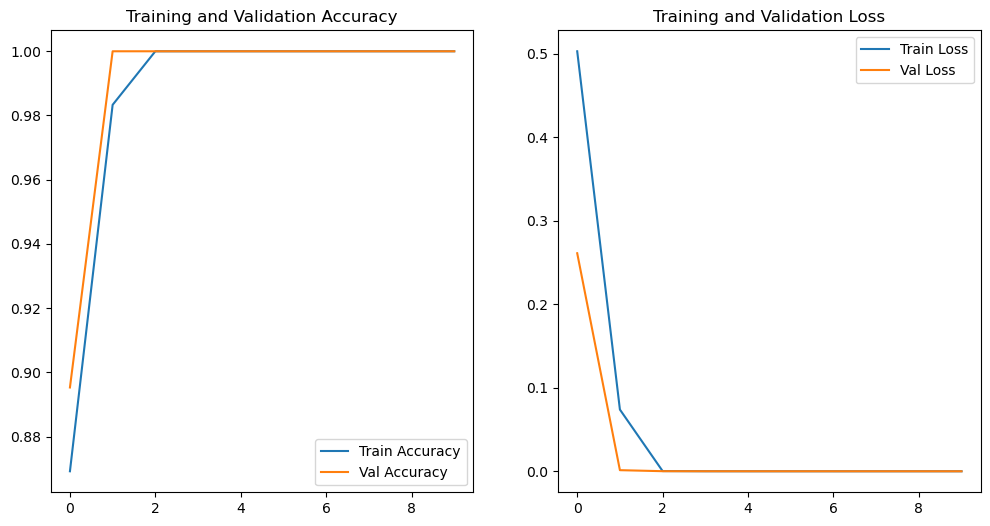

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [64]:
test_data = r"C:\Users\Karan\Desktop\datascience\Projects\Fake_Currency\datasets\fakedata\training\200 Fake\2.jpeg"
test_data_path = test_data

img = keras.preprocessing.image.load_img(
    test_data_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
This image most likely belongs to 200 Fake with a 100.00 percent confidence.


In [72]:
test_data = r"C:\Users\Karan\Desktop\datascience\Projects\Fake_Currency\datasets\fakedata\training\100 Real\5.jpeg"
test_data_path = test_data

img = keras.preprocessing.image.load_img(
    test_data_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
This image most likely belongs to 100 Real with a 100.00 percent confidence.


In [77]:
test_data = r"C:\Users\Karan\Desktop\datascience\Projects\Fake_Currency\datasets\fakedata\training\200 Real\2.jpeg"
test_data_path = test_data

img = keras.preprocessing.image.load_img(
    test_data_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
This image most likely belongs to 200 Real with a 100.00 percent confidence.


In [78]:
test_data = r"C:\Users\Karan\Desktop\datascience\Projects\Fake_Currency\datasets\fakedata\training\100 Real\1 - Copy (2).jpeg"
test_data_path = test_data

img = keras.preprocessing.image.load_img(
    test_data_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
This image most likely belongs to 100 Real with a 100.00 percent confidence.


In [79]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    data_dir, # Put your path here
     target_size=(img_width, img_height),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 4347 images belonging to 7 classes.


C:\Users\Karan\AppData\Local\Temp\ipykernel_16972\2557316206.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)
c:\Users\Karan\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


136/136 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step


In [88]:
true_classes = test_data_generator.classes
class_names = list(test_data_generator.class_indices.keys())

results = pd.DataFrame({
    'Image': test_data_generator.filenames,
    'Predicted Class': [class_names[i] for i in predicted_classes]
})

# Save results to CSV
results.to_csv('predictions.csv', index=False)
print("Sample predictions:")
print(results.head())

Sample predictions:
                      Image Predicted Class
0    100 Fake\1 - Copy.jpeg        100 Fake
1           100 Fake\1.jpeg        100 Fake
2   100 Fake\10 - Copy.jpeg        100 Fake
3          100 Fake\10.jpeg        100 Fake
4  100 Fake\100 - Copy.jpeg        100 Fake


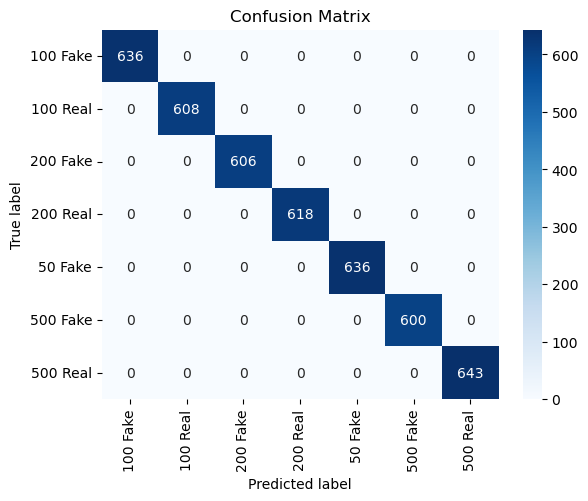

In [98]:
mask = np.zeros_like(conf_matrix, dtype=bool)
sns.heatmap(conf_matrix, mask=mask,annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [102]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate precision
precision = precision_score(true_classes, predicted_classes, average='weighted')
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(true_classes, predicted_classes, average='weighted')
print(f'Recall: {recall:.2f}')

# Calculate F1-score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print(f'F1 Score: {f1:.2f}')

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


In [123]:
model = load_model("fake_currency.h5")

Model loaded and compiled successfully.


In [124]:
model_json=model.to_json()
with open("fake_currency.json","w") as file:
    file.write(model_json)

print("Model architecture saved to fake_currency.json")

Model architecture saved to fake_currency.json
